In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import random
import os
from glob import glob
from tqdm import tqdm
import datetime
from datetime import timedelta
import copy
import zipfile

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import tensorflow as tf

In [5]:
pd.options.display.max_columns = None

In [6]:
CFG = {
    'EPOCHS': 5,
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 16,
    'SEED': 42
}


In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(CFG['SEED'])  # Seed 고정


In [8]:
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
class CustomDataset(Dataset):
    def __init__(self, input_paths, target_paths, infer_mode):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.infer_mode = infer_mode

        self.data_list = []
        self.label_list = []
        print('Data Pre-processing..')
        for input_path, target_path in tqdm(zip(self.input_paths, self.target_paths)):
            input_df = pd.read_csv(input_path)
            target_df = pd.read_csv(target_path)

            input_df = input_df.drop(columns=['시간'])
            input_df = input_df.fillna(0)

            input_length = int(len(input_df)/1440)
            target_length = int(len(target_df))

            for idx in range(target_length):
                time_series = input_df[1440*idx:1440*(idx+1)].values
                self.data_list.append(torch.Tensor(time_series))
            for label in target_df["rate"]:
                self.label_list.append(label)
        print('Done.')

    def __getitem__(self, index):
        data = self.data_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.data_list)


## 1. 데이터 불러오기

In [10]:
base_path = '/Users/seul/seulhub/2022_likelion_dataset/Bok_choy'


In [11]:
train_input_files = sorted(glob(f'{base_path}/train_input/*.csv'))
train_target_files = sorted(glob(f'{base_path}/train_target/*.csv'))
train_input_files[0], train_target_files[0]


('/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/train_input/CASE_01.csv',
 '/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/train_target/CASE_01.csv')

In [12]:

test_input_list = sorted(glob(f'{base_path}/test_input/*.csv'))
test_target_list = sorted(glob(f'{base_path}/test_target/*.csv'))
test_input_list[0], test_target_list[0]


('/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/test_input/TEST_01.csv',
 '/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/test_target/TEST_01.csv')

In [14]:
len(train_input_files), len(train_target_files), len(test_input_list), len(test_target_list)

(58, 58, 6, 6)

### columns 동일한지 확인

In [15]:
cols = sorted(pd.read_csv(train_input_files[0]).columns)
print(cols)

['CO2관측치', 'EC관측치', '기준온도', '난방부하', '난방상태', '난방온도', '난방작동남은시간', '내부습도관측치', '내부온도관측치', '내부유동팬상태', '내부유동팬작동남은시간', '냉방부하', '냉방상태', '냉방온도', '냉방작동남은시간', '레드 LED동작강도', '레드 LED상태', '레드 LED작동남은시간', '백색광추정광량', '블루 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '시간', '외부습도관측치', '외부온도관측치', '외부환기팬상태', '외부환기팬작동남은시간', '일간누적분무량', '적색광추정광량', '청색광추정광량', '총추정광량', '최근분무량', '카메라상태', '펌프상태', '펌프작동남은시간', '화이트 LED동작강도', '화이트 LED상태', '화이트 LED작동남은시간']


In [16]:
file_cnts = len(train_input_files)

In [17]:
cnt = 0
check_idx = []
for i, data in enumerate(train_input_files):
    file_cols = sorted(pd.read_csv(data).columns)
    if file_cols != cols:
        check_idx.append(i)
        cnt += 1
        # print(file_cols)
print(f'Total {file_cnts} files')
print(f"We should check columns of {cnt} files")
print(check_idx)

Total 58 files
We should check columns of 28 files
[9, 17, 29, 30, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [18]:
feature_list = pd.read_csv(train_input_files[0]).columns
print(feature_list)
print()
print(f'=> Total {len(feature_list)} columns')

Index(['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치',
       '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태',
       '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
       '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
       '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
       '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량'],
      dtype='object')

=> Total 38 columns


In [21]:
len(train_input_files)

58

In [24]:
train_input_list = train_input_files[:50]
train_target_list = train_target_files[:50]
val_input_list = train_input_files[50:]
val_target_list = train_target_files[50:]


## 2. 파일 하나로 합치기

In [25]:
train_dataset = CustomDataset(train_input_list, train_target_list, False)
train_loader = DataLoader(
    train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_input_list, val_target_list, False)
val_loader = DataLoader(
    val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)


Data Pre-processing..


50it [00:06,  7.27it/s]


Done.
Data Pre-processing..


8it [00:00,  9.41it/s]

Done.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, input_paths, target_paths, infer_mode):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.infer_mode = infer_mode

        self.data_list = []
        self.label_list = []
        print('Data Pre-processing..')
        for input_path, target_path in tqdm(zip(self.input_paths, self.target_paths)):
            input_df = pd.read_csv(input_path)
            target_df = pd.read_csv(target_path)

            input_df = input_df.drop(columns=['시간'])
            input_df = input_df.fillna(0)

            input_length = int(len(input_df)/1440)
            target_length = int(len(target_df))

            # for idx in range(target_length):
            #     time_series = input_df[1440*idx:1440*(idx+1)].values
            #     self.data_list.append(torch.Tensor(time_series))
            for label in target_df["rate"]:
                self.label_list.append(label)
        print('Done.')

    def __getitem__(self, index):
        data = self.data_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.data_list)


### EDA

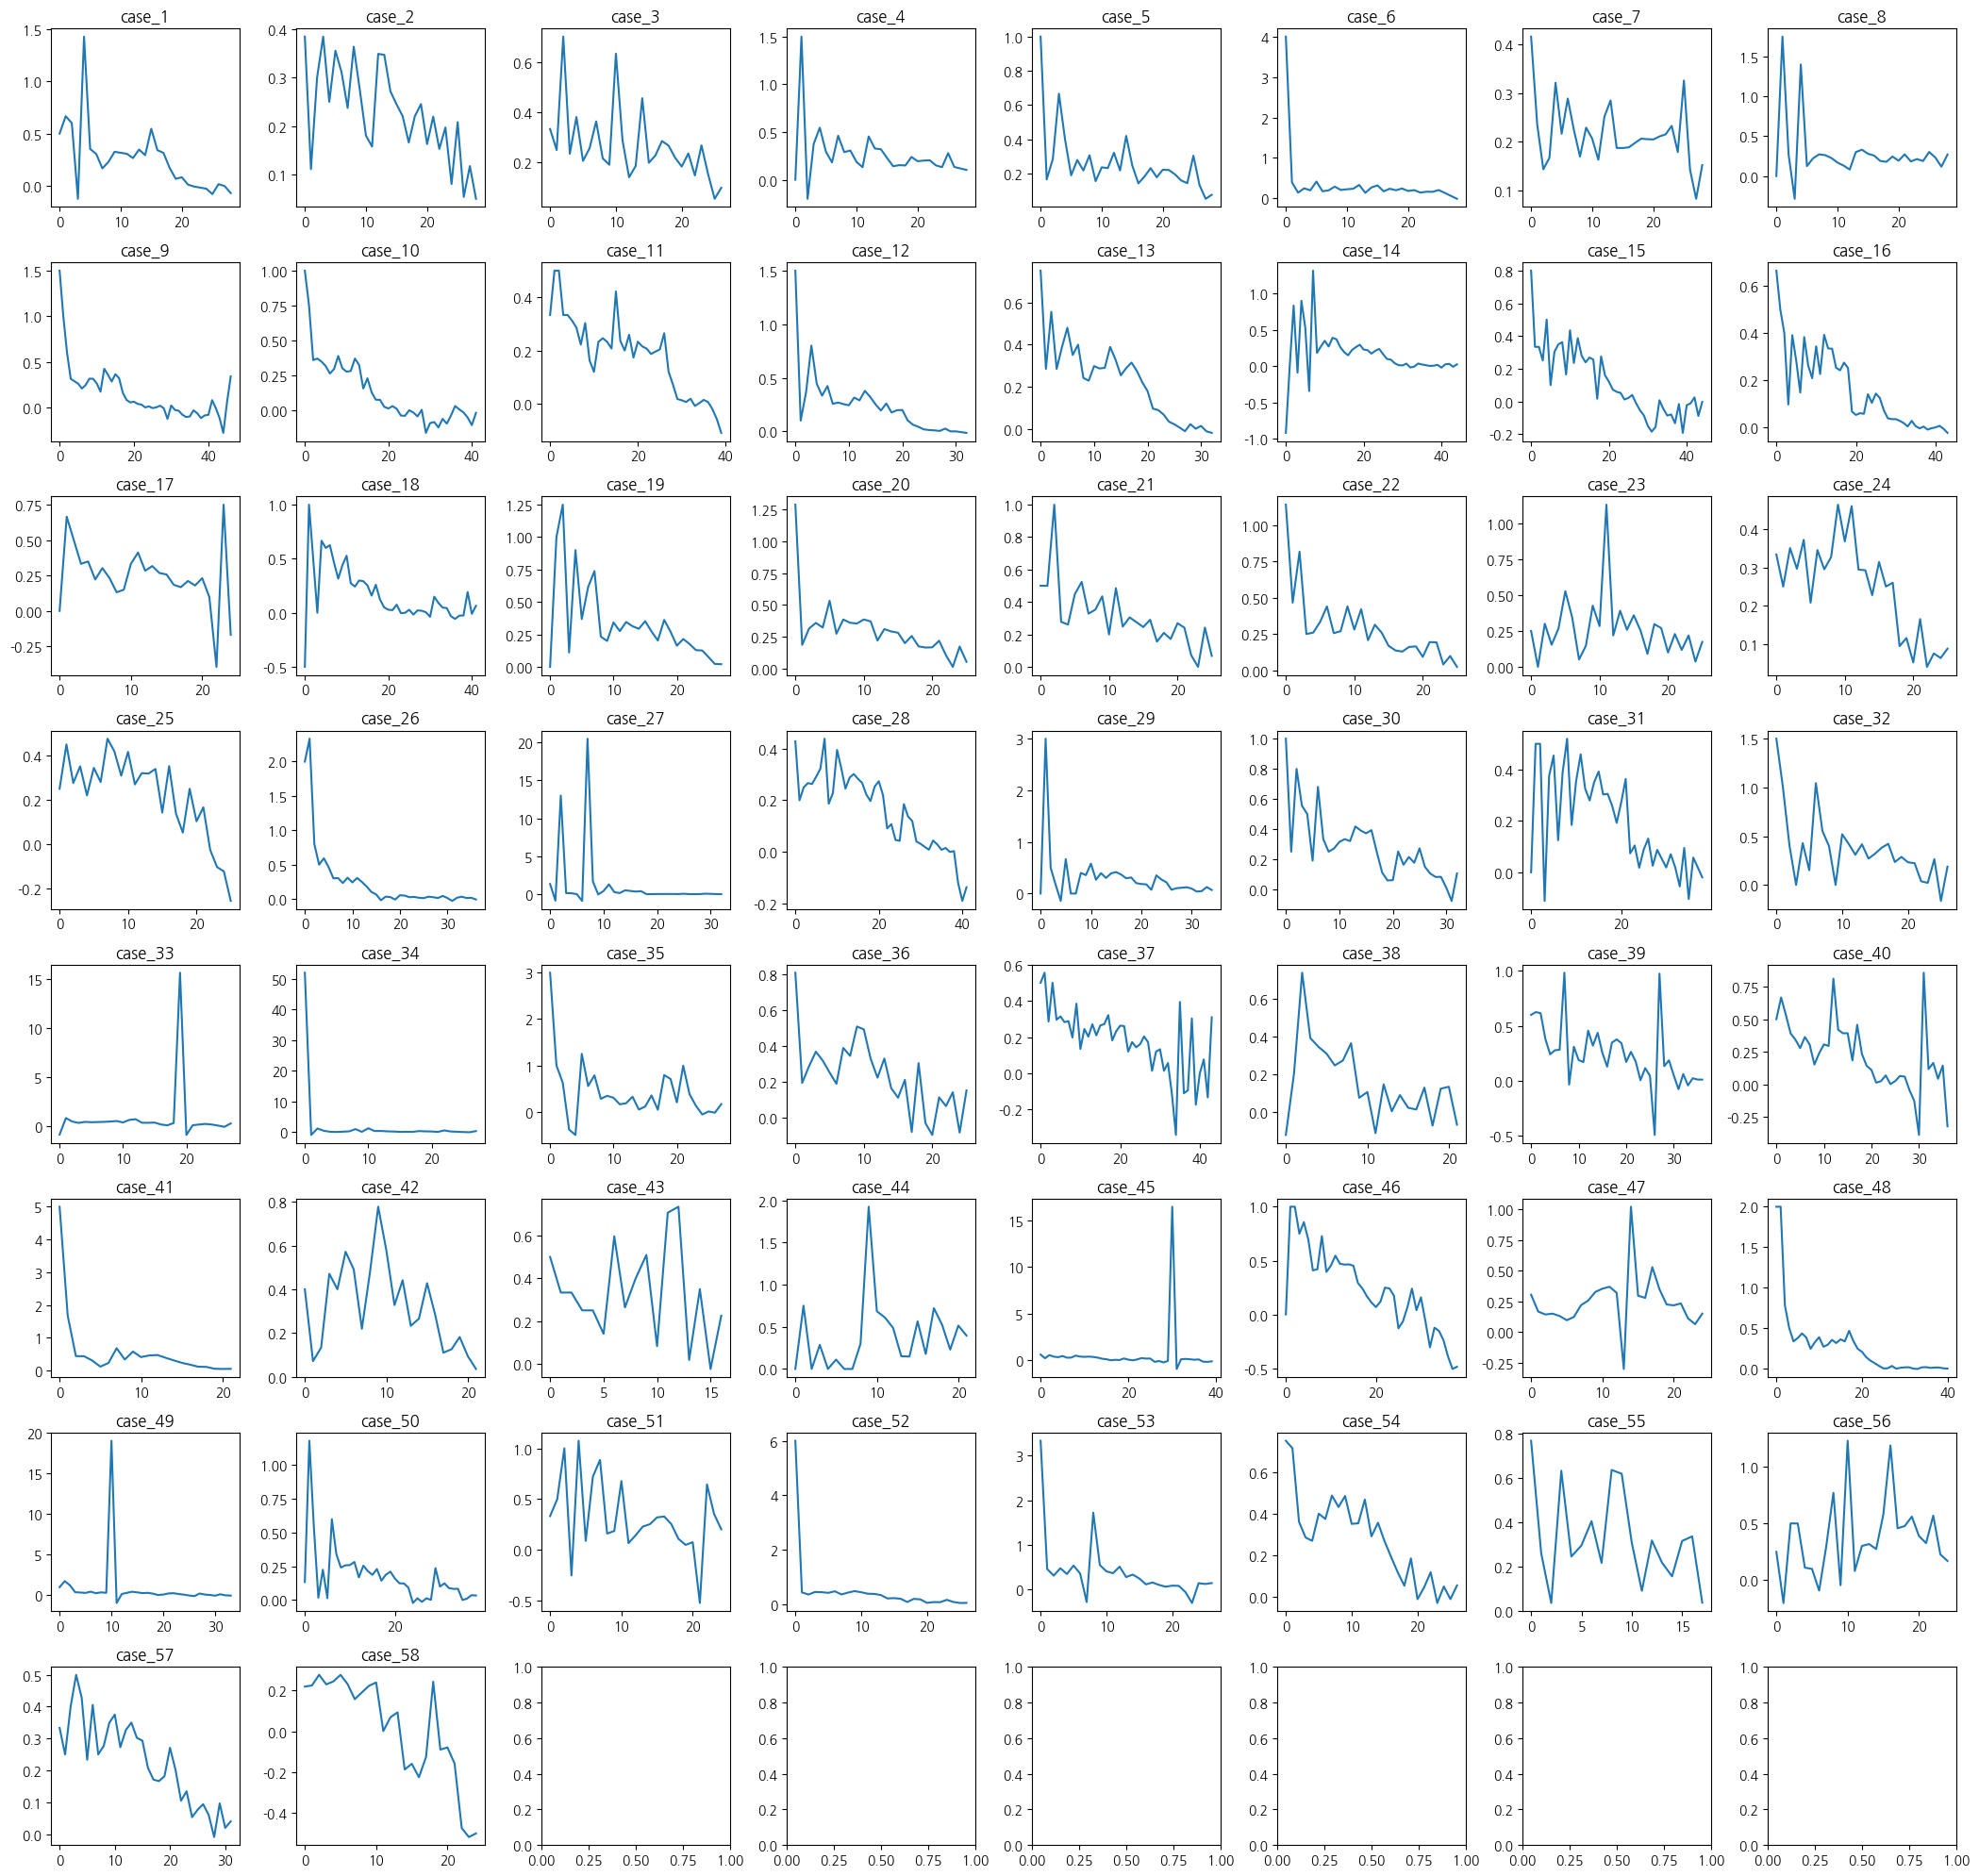

In [21]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(21, 20))
axs = axs.ravel(order='C')
for i, v in enumerate(train_df["case"].unique()):
    axs[i].plot(train_df["rate"][train_df["case"] == v].reset_index(drop=True))
    axs[i].set_title(f"case_{v}")
plt.tight_layout()
plt.show()

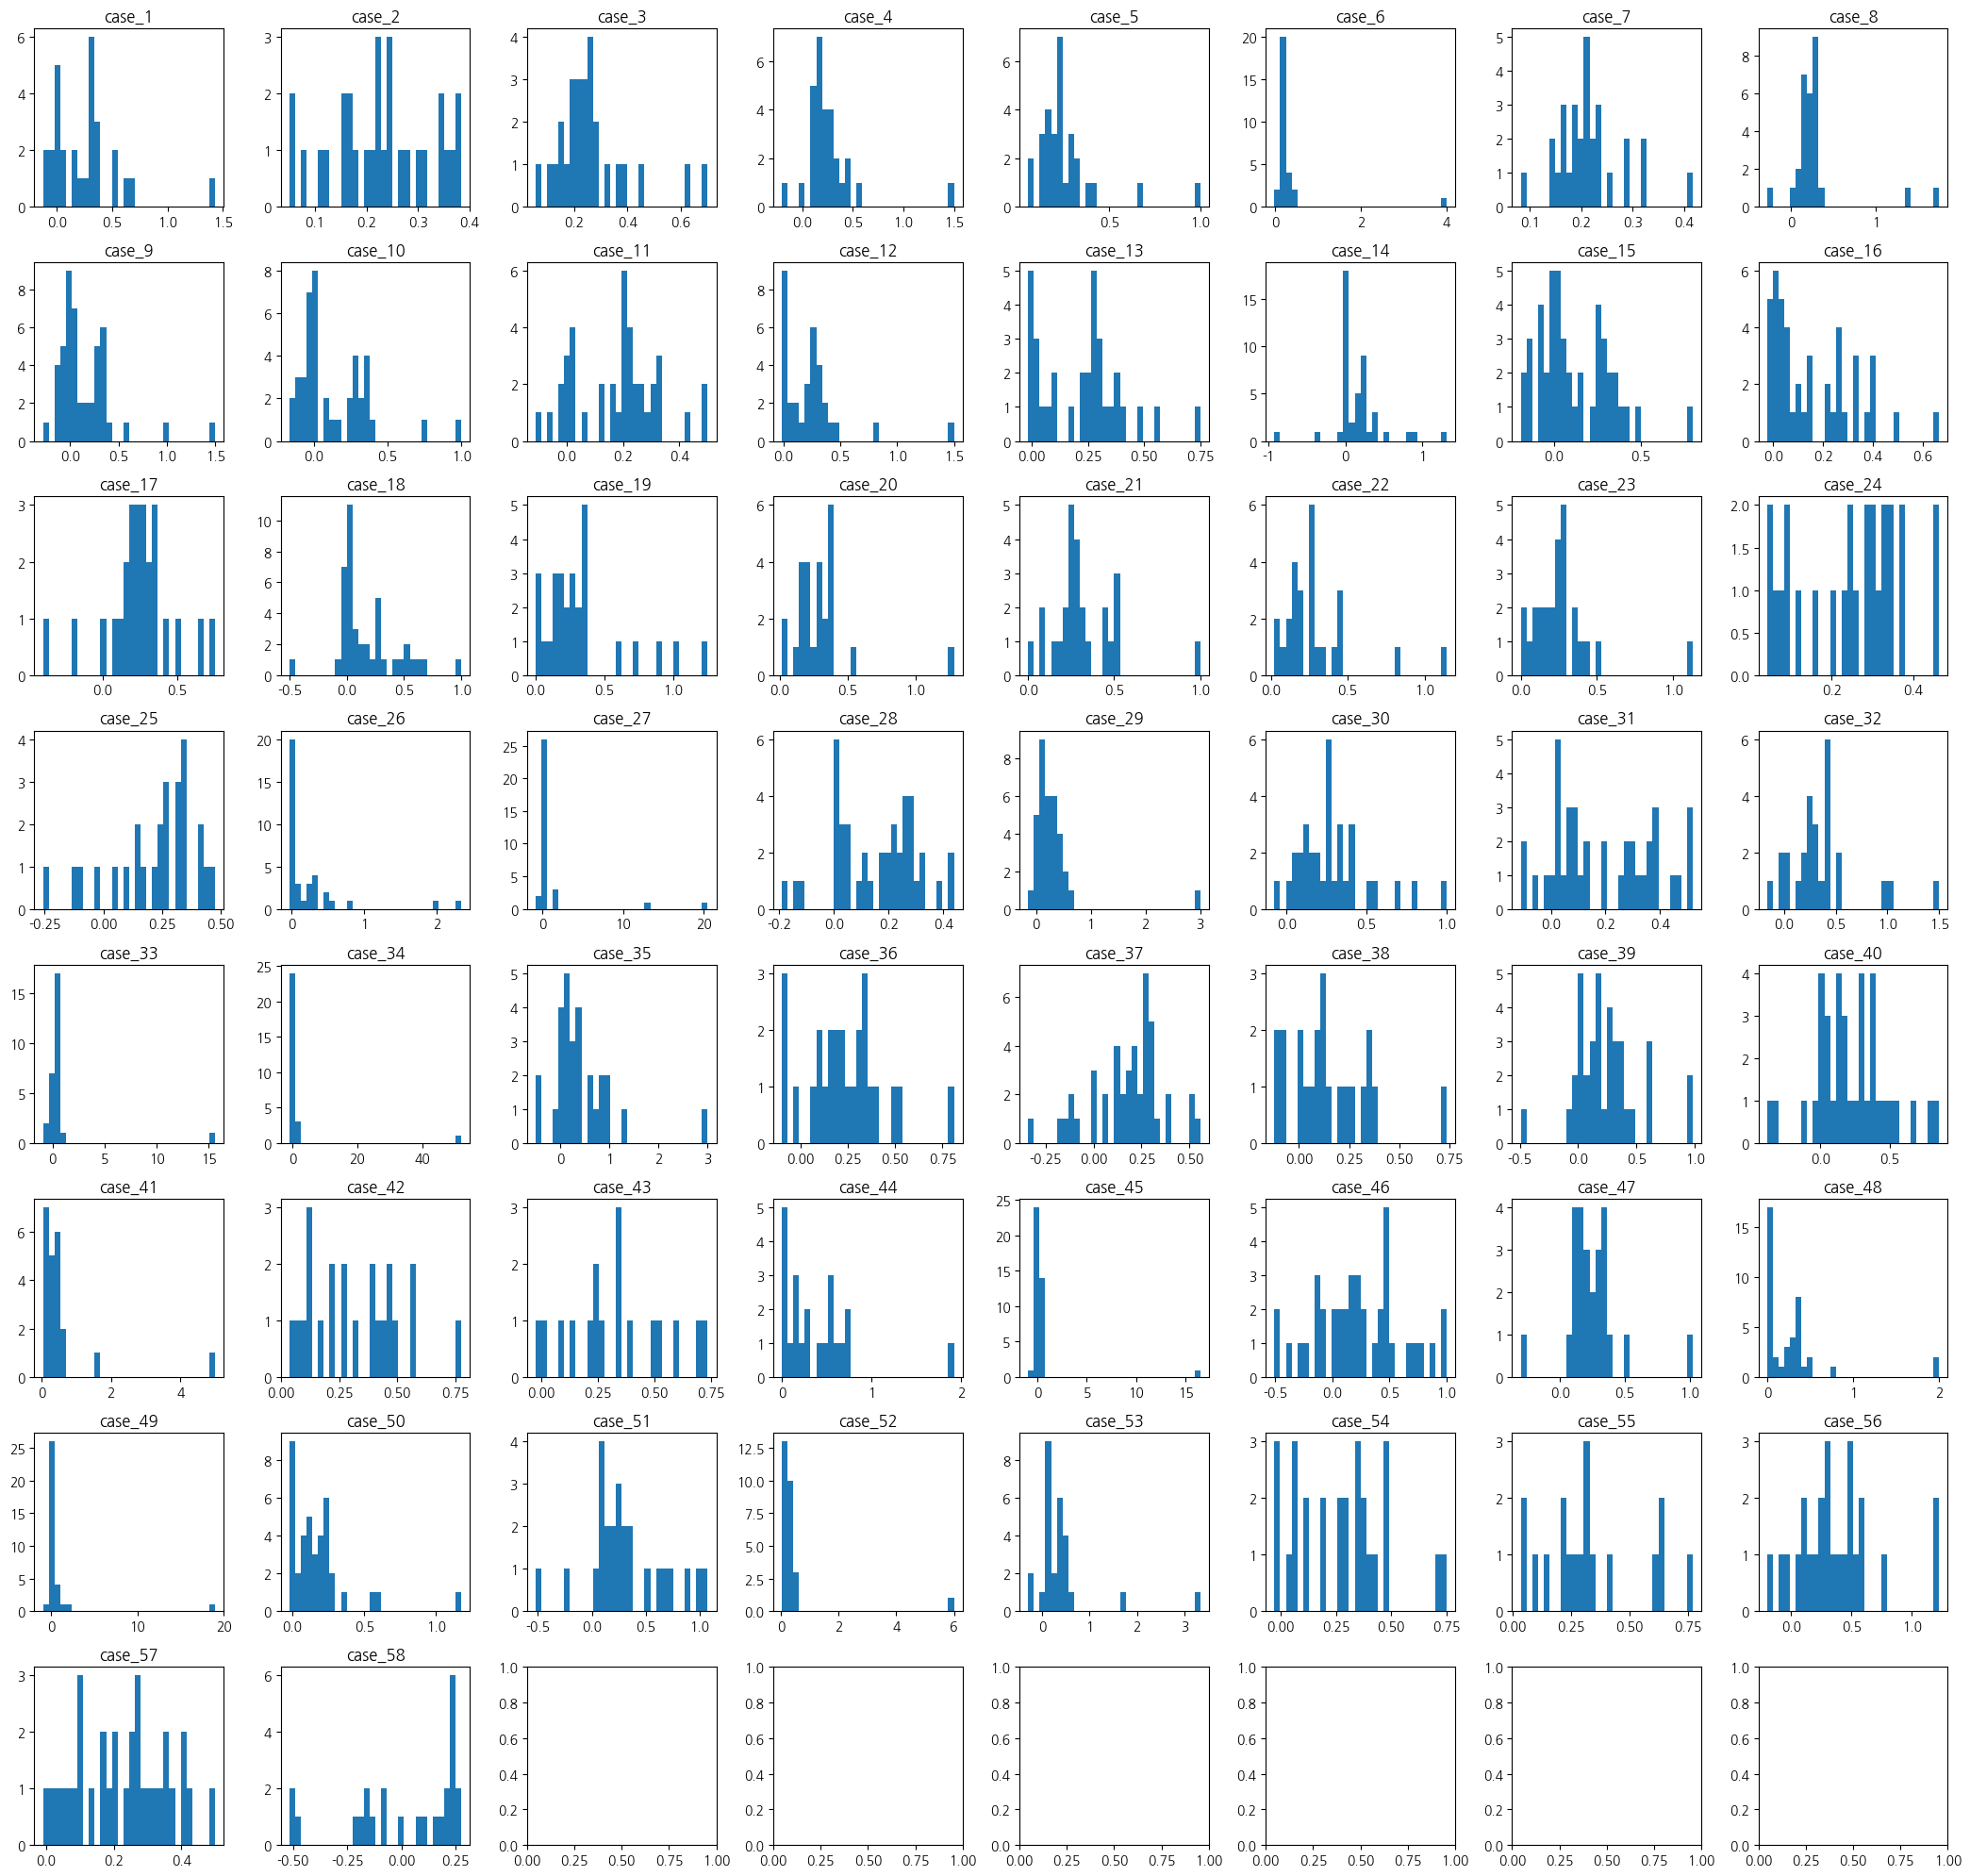

In [22]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(21, 20))
axs = axs.ravel(order='C')
for i, v in enumerate(train_df["case"].unique()):
    axs[i].hist(train_df["rate"][train_df["case"] ==
                v].reset_index(drop=True), bins=30)
    axs[i].set_title(f"case_{v}")
plt.tight_layout()
plt.show()


## 3. 결측치

### 결측치 확인

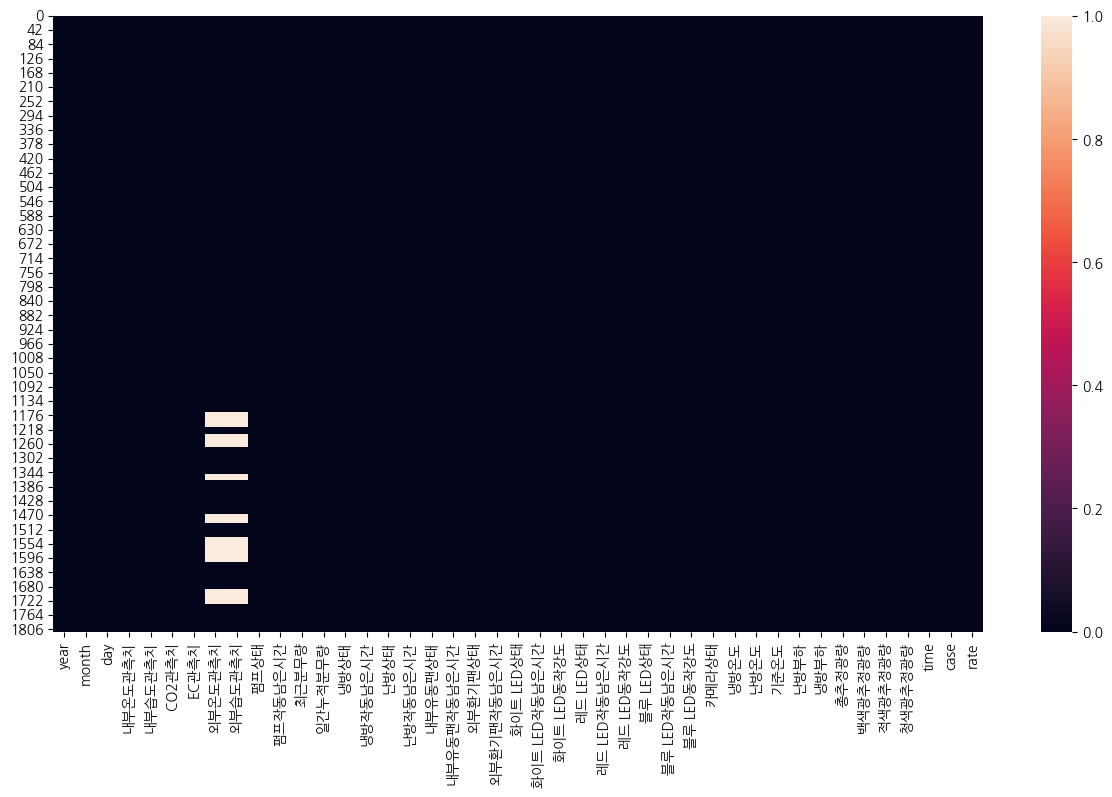

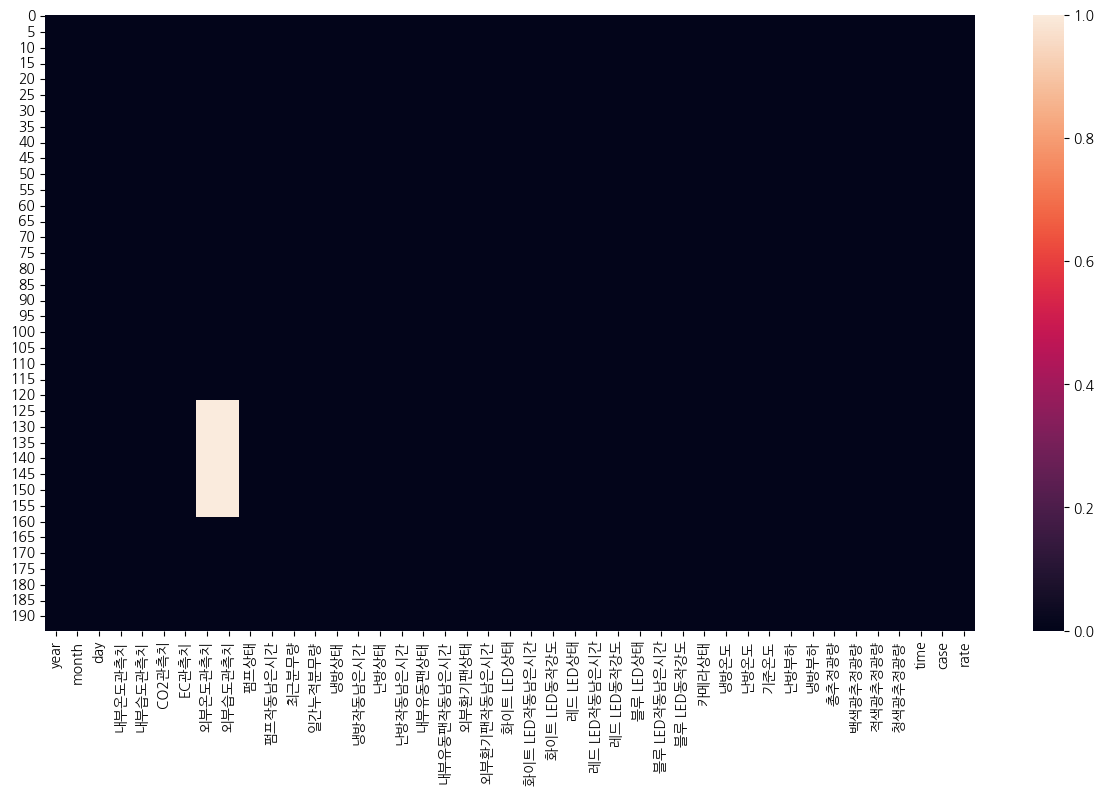

In [23]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_df.isnull())
plt.show()

plt.figure(figsize=(15, 8))
sns.heatmap(test_df.isnull())
plt.show()


In [24]:
# 결측치
train_df.isnull().sum()[train_df.isnull().sum() > 0]


외부온도관측치    241
외부습도관측치    241
dtype: int64

In [25]:
# 결측치
test_df.isnull().sum()[test_df.isnull().sum() > 0]


외부온도관측치    37
외부습도관측치    37
dtype: int64

### 결측치 처리

In [26]:
train_df = train_df.fillna(method="bfill")
test_df = test_df.fillna(method="bfill")

train_df.shape, test_df.shape

((1813, 43), (195, 43))

In [27]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

## 4. 파생변수

### Season

In [28]:
def season(x):
    if x in [3, 4, 5]:
        return 'spring'
    elif x in [6, 7, 8]:
        return 'summer'
    elif x in [9, 10, 11]:
        return 'fall'
    elif x in [12, 1, 2]:
        return 'winter'
    else:
        return np.nan

In [29]:
train_df['Season'] = train_df['month'].apply(season)
train_df['Season'].value_counts()

spring    1159
summer     345
winter     234
fall        75
Name: Season, dtype: int64

In [30]:
test_df['Season'] = test_df['month'].apply(season)
test_df['Season'].value_counts()

spring    140
winter     29
summer     26
Name: Season, dtype: int64

In [32]:
train_df.select_dtypes(include = 'object').columns

Index(['Season'], dtype='object')

In [37]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
test_df['fall'] = 0
train_df.shape, test_df.shape

((1813, 47), (195, 47))

((1813, 47), (195, 47))

## 5. 필요없는 변수 제거

In [39]:
train_df

,year,month,day,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,time,case,rate,Season_fall,Season_spring,Season_summer,Season_winter
0,2021,2,18,22.299999,26.700001,397.0,0.917129,19.100000,10.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,129.0,100.0,201.0,132.0,0.0,201.0,133.5,0.0,0.0,21.663786,19.663786,20.705163,0.0,1.000004,0.0000,0.00000,0.0000,0.00000,0,1,0.50000,0,0,0,1
1,2021,2,19,21.900000,33.299999,357.0,0.910134,17.700001,11.100000,0.0,0.0,769.0,6901.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,251.0,100.0,201.0,252.0,61.0,201.0,253.0,5.0,0.0,21.665922,19.665922,20.665922,0.0,0.000000,0.0000,0.00000,0.0000,0.00000,1,1,0.66667,0,0,0,1
2,2021,2,20,22.150001,31.349999,354.0,0.910134,18.100000,13.400000,0.0,0.0,769.0,6132.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,249.0,100.0,201.0,252.0,61.0,201.0,255.0,5.0,0.0,21.666866,19.666866,20.666866,0.0,0.000000,0.0000,0.00000,0.0000,0.00000,2,1,0.60000,0,0,0,1
3,2021,2,21,23.600000,23.100000,349.0,0.910134,20.200001,20.299999,0.0,0.0,769.0,6139.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.5,201.0,251.0,100.0,201.0,252.0,61.0,201.0,255.0,5.0,0.0,21.665137,19.665137,20.665137,0.0,1.999998,0.0000,0.00000,0.0000,0.00000,3,1,-0.12500,0,0,0,1
4,2021,2,22,24.650001,44.799999,373.0,0.910134,22.000000,22.500000,0.0,0.0,769.0,5766.20,201.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,252.0,100.0,201.0,253.5,61.0,201.0,255.0,5.0,0.0,21.675179,19.675179,20.675179,0.0,3.999996,0.0000,0.00000,0.0000,0.00000,4,1,1.42857,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2022,6,11,23.799999,65.800003,459.0,0.011633,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3567.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,101.0,31.0,201.0,103.0,4.0,201.0,105.0,4.0,0.0,16.666686,14.003576,15.428755,0.0,40.500002,111.7692,95.91710,6.6192,6.26600,20,58,-0.07888,0,0,1,0
1809,2022,6,12,23.500000,64.199997,505.0,0.010857,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3566.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,103.0,31.0,201.0,105.0,4.0,201.0,107.0,3.0,0.0,16.664980,14.004000,15.425492,0.0,40.500002,111.7692,95.91710,6.6192,4.69950,21,58,-0.15838,0,0,1,0
1810,2022,6,13,23.250000,63.200001,415.5,0.010082,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3567.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,101.0,32.0,201.0,103.0,4.0,201.0,105.0,4.0,0.0,16.662264,14.001588,15.433483,0.0,38.999996,111.3481,95.91710,6.6192,5.48275,22,58,-0.47374,0,0,1,0
1811,2022,6,14,23.299999,63.200001,479.0,0.010082,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3565.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,102.0,32.0,201.0,104.0,4.0,201.0,106.0,4.0,0.0,16.666138,14.002086,15.426235,0.0,36.999998,111.7692,99.01120,6.6192,6.26600,23,58,-0.51767,0,0,1,0


In [ ]:
# case 예측할 때 필요없음

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model
